<link rel="preconnect" href="https://fonts.gstatic.com">
<link href="https://fonts.googleapis.com/css2?family=Fira+Code&display=swap" rel="stylesheet">

### License

<p style="font-family: 'Fira Code', monospace; font-size: 1.2rem">
Copyright 2021-2022 Xilinx, Inc.<br><br>
Licensed under the Apache License, Version 2.0 (the "License");<br>
you may not use this file except in compliance with the License.<br><br>
You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0"?>http://www.apache.org/licenses/LICENSE-2.0</a><br><br>
Unless required by applicable law or agreed to in writing, software<br>
distributed under the License is distributed on an "AS IS" BASIS,<br>
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.<br>
See the License for the specific language governing permissions and<br>
limitations under the License.<br>
</p>


# ChipScoPy DDR 2D Eye Margin Scan Example


<img src="../img/api_overview.png" width="500" align="left">

## Description
This demo shows how to exercise and run Versal DDRMC 2D Margin Scan features


## Requirements
- Local or remote Xilinx Versal board, such as a VCK190
- Xilinx hw_server 2022.2 installed and running
- Xilinx cs_server 2022.2 installed and running
- Python 3.8 or greater installed
- ChipScoPy 2022.2 installed
- Jupyter notebook support and extra libs needed - Please do so, using the command `pip install chipscopy[core-addons]`

## 1 - Initialization: Imports and File Paths

After this step,
- Required functions and classes are imported
- URL paths are set correctly
- File paths to example files are set correctly

In [1]:
import sys
import os
import pprint
from chipscopy import create_session, delete_session, report_versions
from chipscopy import get_design_files
from ddr_scan_util import convert_vref_pct_to_code

In [2]:
# Make sure to start the hw_server and cs_server prior to running.
# Specify locations of the running hw_server and cs_server below.
# The default is localhost - but can be other locations on the network.
CS_URL = os.getenv("CS_SERVER_URL", "TCP:localhost:3042")
HW_URL = os.getenv("HW_SERVER_URL", "TCP:localhost:3121")

# The get_design_files() function tries to find the PDI and LTX files. In non-standard
# configurations, you can put the path for PROGRAMMING_FILE and PROBES_FILE below.
design_files = get_design_files("vck190/production/chipscopy_ced")

PROGRAMMING_FILE = design_files.programming_file
PROBES_FILE = design_files.probes_file

print(f"HW_URL: {HW_URL}")
print(f"CS_URL: {CS_URL}")
print(f"PROGRAMMING_FILE: {PROGRAMMING_FILE}")
print(f"PROBES_FILE:{PROBES_FILE}")

HW_URL: TCP:localhost:3121
CS_URL: TCP:localhost:3042
PROGRAMMING_FILE: C:\wrk\chipscopy\chipscopy\examples\designs\vck190\production\chipscopy_ced\chipscopy_wrapper.pdi
PROBES_FILE:C:\wrk\chipscopy\chipscopy\examples\designs\vck190\production\chipscopy_ced\chipscopy_wrapper.ltx


In [3]:
# Which DDRMC target (0..3) for given ACAP
DDR_INDEX = 0
# Which Rank of the memory interface
RANK = 0
# Read or Write Margin : "READ" "WRITE"
MARGIN_MODE = "READ"
# Data pattern used for margin check : "SIMPLE" "COMPLEX"
DATA_PATTERN = "COMPLEX"
# VREF Percentage Minimum (reccommended: Read :DDR4 25, LP4 5 , Write : DDR4 60  , LP4 10)
VREF_PCT_MIN = 25
# VREF Percentage Maximum (reccommended: Read:DDR4 50 , LP4 35 , Write : DDR4 90  , LP4 30)
VREF_PCT_MAX = 50
# Steps to show in the 2D eye scan  ( 1 step takes ~1 second to capture)
STEPS = 15
# Which nibble (read mode) or byte lane (write) to display
DISPLAY_INDEX = 1

## 2 - Create a session and connect to the hw_server and cs_server

The session is a container that keeps track of devices and debug cores.
After this step,
- Session is initialized and connected to server(s)
- Versions are detected and reported to stdout

In [4]:
session = create_session(cs_server_url=CS_URL, hw_server_url=HW_URL)
report_versions(session)

## 3 - Program the device with the example design

After this step,
- Device is programmed with the example programming file

In [5]:
# Typical case - one device on the board - get it.
device = session.devices.filter_by(family="versal").get()
device.program(PROGRAMMING_FILE)

Output()

## 4 - Discover Debug Cores

Debug core discovery initializes the chipscope server debug cores. This brings debug cores in the chipscope server online.

After this step,

- The cs_server is initialized and ready for use

In [6]:
device.discover_and_setup_cores(ltx_file=PROBES_FILE)
print(f"Debug cores setup and ready for use.")

Debug cores setup and ready for use.


## 5 - Get a list of the integrated DDR Memory Controllers

In [7]:
ddr_list = device.ddrs
print(f"{len(ddr_list)} integrated DDRMC cores exist on this device.")

ddr_index = 0
for ddr in ddr_list:
    if ddr.is_enabled:
        print(f" DDRMC instance {ddr_index} is enabled")
    else:
        print(f" DDRMC instance {ddr_index} is disabled")
    ddr_index += 1

4 integrated DDRMC cores exist on this device.
 DDRMC instance 0 is enabled
 DDRMC instance 1 is disabled
 DDRMC instance 2 is disabled
 DDRMC instance 3 is disabled


## 6- Select a target DDR by index and display calibration status

In [8]:
try:
    ddr = ddr_list[DDR_INDEX]
    props = ddr.ddr_node.get_property(["cal_status"])
    print(f"Calibration status of DDRMC instance {DDR_INDEX} is {props['cal_status']}")
except:
    print(f"The DDR controller at index {DDR_INDEX} is not in use")

Calibration status of DDRMC instance 0 is PASS


In [9]:
## Initialize and activate the Margin Check feature in the DDRMC
ddr.ddr_node.set_property({"mgchk_enable": 1})
ddr.ddr_node.commit_property_group([])
ddr.ddr_node.set_property({"mgchk_enable": 0})
ddr.ddr_node.commit_property_group([])
print("Initialization complete.")

Initialization complete.


## 7 - Setting the 2D eye scan read or write mode

In [10]:
if MARGIN_MODE == "READ":
    print("Setting 2D eye for READ margin")
    ddr.set_eye_scan_read_mode()
elif MARGIN_MODE == "WRITE":
    print("Setting 2D eye for WRITE margin")
    ddr.set_eye_scan_write_mode()
else:
    print(
        f" ERROR: MARGIN_MODE is set to {MARGIN_MODE} which is an illegal value, only READ or WRITE is allowed"
    )


Setting 2D eye for READ margin


## 8 - Setting the 2D eye scan data pattern mode

In [11]:
if DATA_PATTERN == "SIMPLE":
    print("Setting 2D eye for SIMPLE data pattern")
    ddr.set_eye_scan_simple_pattern()
elif DATA_PATTERN == "COMPLEX":
    print("Setting 2D eye for COMPLEX data pattern")
    ddr.set_eye_scan_complex_pattern()
else:
    print(
        f" ERROR: DATA_PATTERN is set to {DATA_PATTERN} which is an illegal value, only SIMPLE or COMPLEX is allowed"
    )

Setting 2D eye for COMPLEX data pattern


## 9 - Setting the Vref sample min/max range

In [12]:
print("Vref Min setting...")
vref_min_code = convert_vref_pct_to_code(ddr, MARGIN_MODE, VREF_PCT_MIN)
print("Vref Max setting...")
vref_max_code = convert_vref_pct_to_code(ddr, MARGIN_MODE, VREF_PCT_MAX)

ddr.set_eye_scan_vref_min(vref_min_code)
ddr.set_eye_scan_vref_max(vref_max_code)
ddr.set_eye_scan_vref_steps(STEPS)
print(f"Dividing the Vref range into {STEPS} steps")


Vref Min setting...
 Requested Read Vref %: 25 actual % : 25.0 
Vref Max setting...
 Requested Read Vref %: 50 actual % : 50.0 
Dividing the Vref range into 15 steps


## 10 - Run 2D Margin Scan after settings

In [13]:
ddr.run_eye_scan()

Output()

## 11 - Display Scan Plots by a given Unit(nibble/byte) index

You can display static or dynamic plots. The display_type controls the display output.
- "static" is a simple image that can be saved.
- "dynamic" is an interactive javascript plot.
- The default is "dynamic".

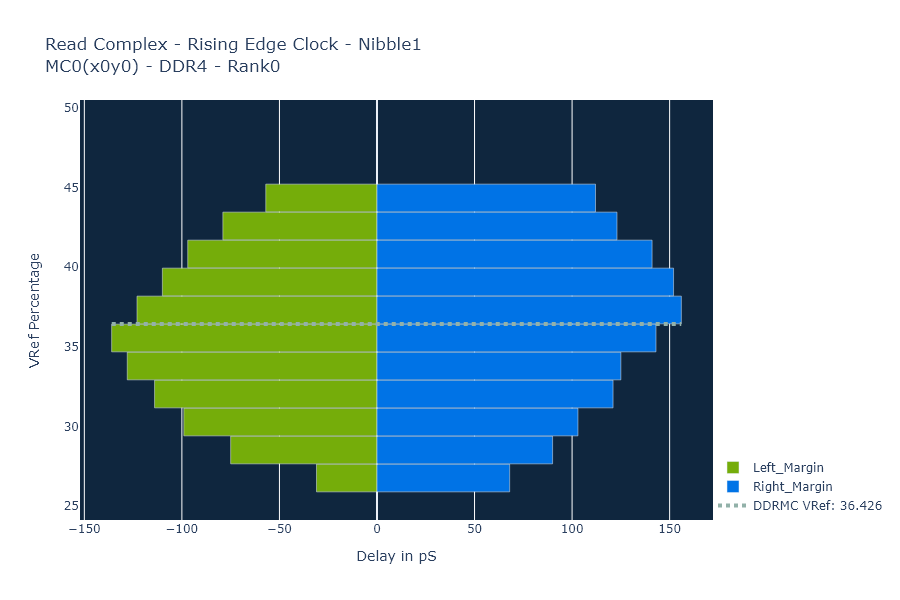

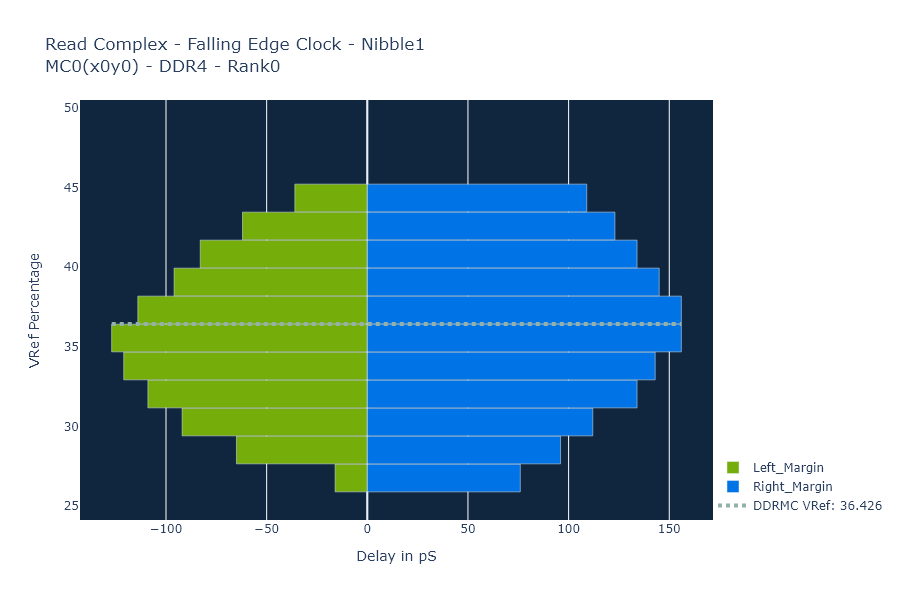

In [14]:
ddr.display_eye_scan(DISPLAY_INDEX, display_type="static")

Optionally you can return figures as a list for later operations.

In [15]:
figs = ddr.display_eye_scan(DISPLAY_INDEX + 1, return_as_list=True)

The following loop demonstrates how you can display the graphs from a list created previously.
It is easy to display interactive or static images.

Here we get the list of figures and output them to png format.

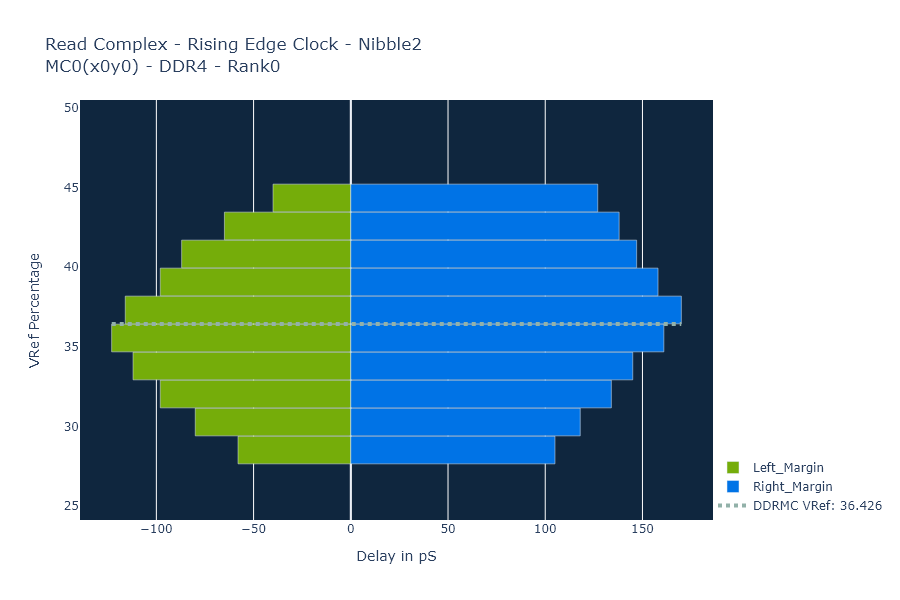

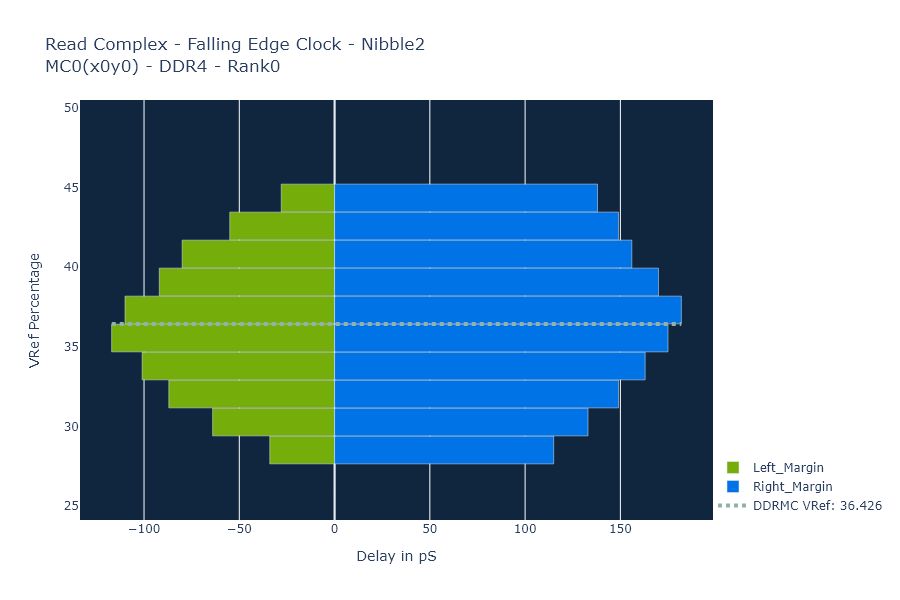

In [16]:
from IPython.display import Image, display

for fig in figs:
    # To display interactive images, uncomment the following line:
    # fig.show()

    # To display a static png image:
    image_bytes = fig.to_image(format="png")
    ipython_image = Image(image_bytes)
    display(ipython_image)


## 12 - Save the Eye Scan data from latest run

In [17]:
ddr.save_eye_scan_data("myoutput.csv")

## 13 - Load Eye Scan data from a given data file

In [18]:
ddr.load_eye_scan_data("myoutput.csv")

## 14 - Review overall Scan status and Control group detail from latest run

In [19]:
props = ddr.ddr_node.get_property_group(["eye_scan_stat", "eye_scan_ctrl"])
print(pprint.pformat(props, indent=2))

{ 'es_data_need_update': 0,
  'es_vref_max': 512,
  'es_vref_min': 256,
  'es_vref_steps': 15,
  'eye_scan_error': 'None',
  'eye_scan_status': 'DONE',
  'mgchk_abort': 0,
  'mgchk_ack': 0,
  'mgchk_bitslect': 0,
  'mgchk_ctrl': 64,
  'mgchk_def_rd_vref_0': 373,
  'mgchk_def_rd_vref_1': 0,
  'mgchk_def_wr_vref': 28,
  'mgchk_def_wr_vref_range': 0,
  'mgchk_done': 0,
  'mgchk_enable': 0,
  'mgchk_enable_status': 1,
  'mgchk_error': 0,
  'mgchk_mode': 1,
  'mgchk_pattern_config_0': 0,
  'mgchk_pattern_config_1': 0,
  'mgchk_pattern_config_2': 0,
  'mgchk_pattern_mode': 1,
  'mgchk_rank': 0,
  'mgchk_rd_vref_0': 508,
  'mgchk_rd_vref_1': 0,
  'mgchk_rw_mode': 0,
  'mgchk_start': 1,
  'mgchk_step': 0,
  'mgchk_unit': 0,
  'mgchk_wr_vref': 0}


## 15 - (Optional) Report Full DDR config and calibration/margin Info

In [20]:
# (uncomment to see report)
# ddr.report()

In [21]:
## When done with testing, close the connection
delete_session(session)